In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns


# data load
df_ab = pd.read_csv('../data/ab_data.csv')
df_ct = pd.read_csv('../data/countries.csv')

# data merge
df = pd.merge(df_ab, df_ct, on='user_id', how='left')

# filter/clean data정제된 실험 데이터로 필터링
mask = ((df.group == 'control') & (df.landing_page != 'old_page')) | \
       ((df.group == 'treatment') & (df.landing_page != 'new_page'))
df = df.loc[~mask].copy()


df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290589 entries, 0 to 294481
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290589 non-null  int64 
 1   timestamp     290589 non-null  object
 2   group         290589 non-null  object
 3   landing_page  290589 non-null  object
 4   converted     290589 non-null  int64 
 5   country       290589 non-null  object
dtypes: int64(2), object(4)
memory usage: 15.5+ MB


(   user_id timestamp      group landing_page  converted country
 0   851104   11:48.6    control     old_page          0      US
 1   804228   01:45.2    control     old_page          0      US
 2   661590   55:06.2  treatment     new_page          0      US
 3   853541   28:03.1  treatment     new_page          0      US
 4   864975   52:26.2    control     old_page          1      US,
 None)

In [2]:
# 1. Calculate number of conversions and totals by group (그룹별 전환 수와 전체 수 계산)
summary = df.groupby('group')['converted'].agg(['sum', 'count']).rename(columns={'sum': 'conversions', 'count': 'total'})
print("🔍 summary of conversions:\n", summary)


🔍 summary of conversions:
            conversions   total
group                         
control          17489  145274
treatment        17264  145315


In [3]:
# 2. Z-test for proportions (conversion rate comparison, 전환율 비교)
count = summary['conversions'].values  # 성공 수
nobs = summary['total'].values         # 전체 수

z_stat, p_value = proportions_ztest(count, nobs)
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("✅ Statistically significant difference found.")
else:
    print("❌ No statistically significant difference.")


Z-statistic: 1.3143
P-value: 0.1887
❌ No statistically significant difference.


In [4]:
# 3. Chi-squared test (test for independence)
contingency = pd.crosstab(df['group'], df['converted'])
chi2, p_chi, _, _ = chi2_contingency(contingency)

print(f"\nChi-squared: {chi2:.4f}")
print(f"Chi-squared P-value: {p_chi:.4f}")



Chi-squared: 1.7125
Chi-squared P-value: 0.1907


In [5]:
# 4. Calculate effect size (Cohen's h), 효과 크기 계산 (Cohen's h)
from math import asin, sqrt

p1 = count[0] / nobs[0]
p2 = count[1] / nobs[1]
cohen_h = 2 * (asin(sqrt(p1)) - asin(sqrt(p2)))

if abs(cohen_h) < 0.2:
    interpret = 'Very small effect'
elif abs(cohen_h) < 0.5:
    interpret = 'Small effect'
elif abs(cohen_h) < 0.8:
    interpret = 'Medium effect'
else:
    interpret = 'Large effect'
    
print(f"\nCohen's h (effect size): {cohen_h:.4f}")
print(f"📏 Interpretation of effect size: {interpret}")



Cohen's h (effect size): 0.0049
📏 Interpretation of effect size: Very small effect


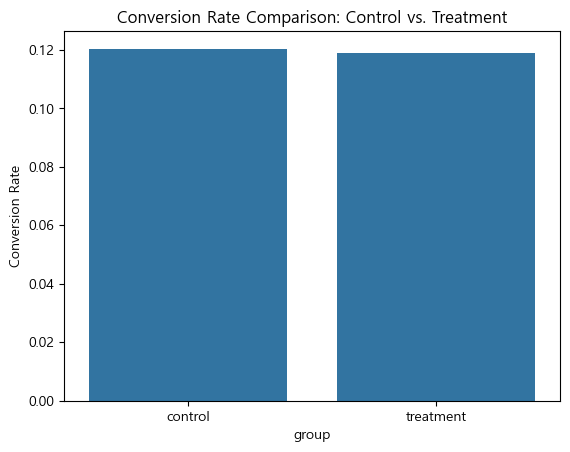

In [6]:
# 5. Visualization - Visualizing difference in conversion rates, 시각화 - 전환율 차이 시각화

import matplotlib.pyplot as plt
import matplotlib as mpl

# Prevent broken characters in Korean font
mpl.rcParams['font.family'] = 'Malgun Gothic'  # For Windows users
mpl.rcParams['axes.unicode_minus'] = False     # Fix for minus sign display

### Font configuration ends here ###

summary['conversion_rate'] = summary['conversions'] / summary['total']
summary.reset_index(inplace=True)

sns.barplot(data=summary, x='group', y='conversion_rate')
plt.title('Conversion Rate Comparison: Control vs. Treatment')
plt.ylabel('Conversion Rate')
plt.savefig('../outputs/figures/3_conversion_rate_comparison.png')
plt.show()


In [7]:
import statsmodels.api as sm

ci_low, ci_upp = sm.stats.proportion_confint(count, nobs, alpha=0.05, method='normal')
print(f"Confidence Interval (Control): [{ci_low[0]:.4f}, {ci_upp[0]:.4f}]")
print(f"Confidence Interval (Treatment): [{ci_low[1]:.4f}, {ci_upp[1]:.4f}]")


Confidence Interval (Control): [0.1187, 0.1221]
Confidence Interval (Treatment): [0.1171, 0.1205]
